# Principal Component Analysis and Support Vector Machine for tumor classification

### Raul Almuzara

------------------------

**Breast Cancer Wisconsin (Original) Dataset** 

UCI Machine Learning Repository: https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original

699 patients who may have a benign tumor (`Class` = 2) or a malignant tumor (`Class` = 4). 

In addition to a `Sample Code Number`, there are 9 biological features rated with integer values from 1 to 10:

`Clump Thickness`

`Uniformity of Cell Size`

`Uniformity of Cell Shape`

`Marginal Adhesion`

`Single Epithelial Cell Size`

`Bare Nuclei`

`Bland Chromatin`

`Normal Nucleoli`

`Mitoses`

We will reduce them into 2 variables with Principal Component Analysis. Then, we will classify the patients with a Support Vector Machine. The objective is to predict the tumor class (benign or malignant) of a patient.

----------------------------

# Preprocessing and preliminary analysis

Libraries

In [1]:
import numpy as np #version 1.24.3
import pandas as pd #version 2.0.1
import matplotlib.pyplot as plt #version 3.7.1
import seaborn as sns #version 0.12.2
from sklearn.model_selection import train_test_split #version 1.3.0
from sklearn.decomposition import PCA #version 1.3.0
from sklearn.svm import SVC #version 1.3.0
from sklearn.metrics import accuracy_score, confusion_matrix #version 1.3.0

We load the data.

In [2]:
colnames = ['Sample Code Number',
            'Clump Thickness',
            'Uniformity of Cell Size',
            'Uniformity of Cell Shape',
            'Marginal Adhesion',
            'Single Epithelial Cell Size',
            'Bare Nuclei',
            'Bland Chromatin',
            'Normal Nucleoli',
            'Mitoses',
            'Class']

data = pd.read_csv('breast-cancer-wisconsin-original.csv', names=colnames, header=None)

We remove instances with missing values and assign the data the integer type.

In [3]:
data = data.replace({'?': np.nan}).dropna().astype(int)

Number of usable rows that will be used from now on:

In [4]:
data.shape[0]

683

Within this set with no missing data, we explore how many instances correspond to patients with a benign tumor and how many to patients with a malignant tumor.

In [5]:
print('There are '+str(len(data[data['Class']==2]))+' patients with a benign tumor')
print('There are '+str(len(data[data['Class']==4]))+' patients with a malignant tumor')

There are 444 patients with a benign tumor
There are 239 patients with a malignant tumor


First instances:

In [6]:
data.head(10)

,Sample Code Number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


We separate the predictor features and the target variable.

In [7]:
X = data[['Clump Thickness',
          'Uniformity of Cell Size',
          'Uniformity of Cell Shape',
          'Marginal Adhesion',
          'Single Epithelial Cell Size',
          'Bare Nuclei',
          'Bland Chromatin',
          'Normal Nucleoli',
          'Mitoses']]

y = data['Class']

We split the data into two sets: a *training set* with 70% of the patients (478) that we will use to train the model and a *test set* with 30% of the patients (205) that will be used to evaluate its predictive ability on data not seen during the training phase. To show specific results throughout the notebook, we will work with the split below, although most splits lead to models that generalize well and have very similar and very high accuracy.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Therefore, in the training set:

In [9]:
print('There are '+str(sum(y_train==2))+' patients with a benign tumor')
print('There are '+str(sum(y_train==4))+' patients with a malignant tumor')

There are 317 patients with a benign tumor
There are 161 patients with a malignant tumor


and in the test set:

In [10]:
print('There are '+str(sum(y_test==2))+' patients with a benign tumor')
print('There are '+str(sum(y_test==4))+' patients with a malignant tumor')

There are 127 patients with a benign tumor
There are 78 patients with a malignant tumor


Since we will then perform a PCA, it is first typical to standardize the variables if they are measured in different units, if they are not on a common scale or if their variances are very different. However, in our case, we do not really have these problems. Despite being very different biological variables, we are not working with the exact physical measurements, but with dimensionless scores of each variable. All the predictors are scores that take integer values in the same interval [1,10] (this is relevant for both the PCA and the SVM algorithms, which are not scale invariant and the attributes should be scaled to common intervals). Also, their variances are in a similar order of magnitude, with none of them being extremely different from the others. Therefore, we will choose NOT to standardize.

Using the training data, we show the correlation matrix of predictors.

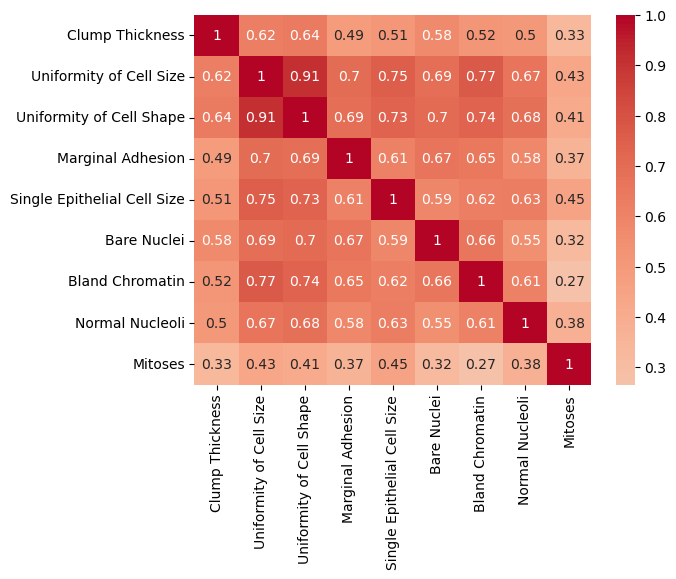

In [11]:
corr_mat = X_train.corr()
sns.heatmap(corr_mat,
            cmap='coolwarm',
            center=0,
            annot=True)
plt.show()

Using the training data, we show the covariance matrix of predictors.

In [12]:
X_train.cov()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
Clump Thickness,7.705727,5.207249,5.326553,3.759884,3.122716,5.785892,3.360069,4.055042,1.387841
Uniformity of Cell Size,5.207249,9.182179,8.281686,5.895126,5.029403,7.557213,5.407700,5.882854,1.974843
Uniformity of Cell Shape,5.326553,8.281686,9.075064,5.787927,4.864065,7.672974,5.196354,5.951646,1.866876
Marginal Adhesion,3.759884,5.895126,5.787927,7.766234,3.741103,6.757752,4.225091,4.707087,1.534591
Single Epithelial Cell Size,3.122716,5.029403,4.864065,3.741103,4.839609,4.716043,3.185811,3.993123,1.498952
Bare Nuclei,5.785892,7.557213,7.672974,6.757752,4.716043,13.093076,5.581555,5.821110,1.708595
Bland Chromatin,3.360069,5.407700,5.196354,4.225091,3.185811,5.581555,5.441787,4.156996,0.928721
Normal Nucleoli,4.055042,5.882854,5.951646,4.707087,3.993123,5.821110,4.156996,8.432519,1.659329
Mitoses,1.387841,1.974843,1.866876,1.534591,1.498952,1.708595,0.928721,1.659329,2.246331


--------------------------------------

# Principal Component Analysis

We are going to perform a PCA to reduce the number of variables to 2 while minimizing the loss of information. This will simplify the development of a classification model and allow visualization of the data and the results.

In [13]:
pca_train = PCA(n_components=2).fit(X_train)
pca_coordinates_train = pca_train.transform(X_train)
df_principal_train = pd.DataFrame(data=pca_coordinates_train, index=X_train.index, columns=['PC1','PC2'])
df_principal_train_with_class = pd.concat([df_principal_train,y_train], axis=1)

Now, each patient has coordinates (PC1,PC2) in the new two-dimensional space.

In [14]:
df_principal_train_with_class

,PC1,PC2,Class
183,11.979034,-0.690050,4
472,-4.870470,-0.295420,2
444,-2.712054,-0.278809,2
85,8.966489,7.771690,4
516,-6.342844,-0.004571,2
...,...,...,...
73,10.371403,-2.476760,4
108,-5.141041,1.189364,2
279,6.211767,-1.039377,4
450,-4.515309,-0.336596,2


Principal components are new orthogonal axes that represent the directions of maximum variance of the projected data. The directions are given by the eigenvectors of the covariance matrix and the corresponding eigenvalues represent the amount of variance that each principal component carries. If we want to reduce the dimension to 2, we choose the two principal components with the largest eigenvalues (i.e., largest explained variance). The proportion of variance explained by each of the selected components is the corresponding eigenvalue of the covariance matrix divided by the sum of all its eigenvalues.

In this case, these are the principal axes chosen:

In [15]:
print(pca_train.components_)

[[ 0.29447477  0.40946517  0.40766498  0.33127233  0.25748142  0.45179924
   0.2815668   0.33137741  0.10089953]
 [-0.05816992  0.22262949  0.19129792 -0.09540687  0.20108903 -0.78277834
   0.03329779  0.47977407  0.12993985]]


The largest eigenvalues of the covariance matrix are the following:

In [16]:
print(pca_train.explained_variance_)

[46.40904299  5.02181103]


Ordered from highest to lowest, each component explains the following proportions of variance (as a ratio between 0 and 1).

In [17]:
print(pca_train.explained_variance_ratio_)

[0.6846756 0.0740871]


Having considered the two components with largest proportion of variance explained, the total proportion explained is the sum.

In [18]:
print(sum(pca_train.explained_variance_ratio_))

0.7587627047010862


In this case, more than 75% of variance is explained with 2 components. This can be deemed acceptable considering that we originally had 9 variables and we have made a considerable reduction.

Graphical representation of patients in 2 dimensions after PCA (Class 2 = Benign tumor and Class 4 = Malignant tumor):

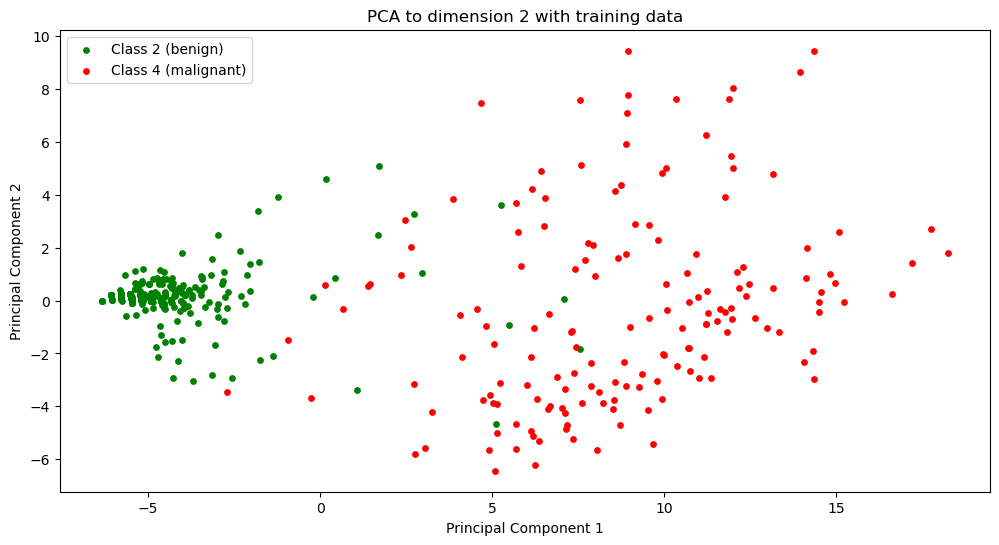

In [19]:
fig = plt.figure(figsize = (12,6))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA to dimension 2 with training data')

classes = [2,4]
colors = ['g','r']

for kind, color in zip(classes, colors):
    indices = df_principal_train_with_class['Class'] == kind
    ax.scatter(df_principal_train_with_class.loc[indices,'PC1'],
               df_principal_train_with_class.loc[indices,'PC2'],
               c=color,
               s=15)
    
ax.legend(['Class 2 (benign)','Class 4 (malignant)'])

plt.show()

------------------------------------

# Support Vector Machine

A Support Vector Machine is a supervised learning model that we can use for classification. The objective is to achieve an appropriate separation of the data according to their classes (in our case, two classes of tumors). Thanks to PCA, we have reduced the data to two dimensions, so the SVM will try to find an optimal separation of the two classes using a curve in the plane. The shape of this curve depends on the choice of a kernel function (see https://scikit-learn.org/stable/modules/svm.html#kernel-functions). We will consider linear, polynomial and radial basis function kernels.

The models will be trained using the data from the training set after the PCA transformation. Then, we will show a first plot displaying these data along with the separating curve that has been derived from them. Keeping this curve, we will make a second plot, but this time showing the data from the test set. Before that, we first have to transform them with the PCA that was fitted for the data from the training set.

In [20]:
pca_coordinates_test = pca_train.transform(X_test)

These instances from the test set were not used to construct the curve of the SVM. Therefore, we will be able to use them to evaluate the predictive power of the model with data that it has not seen before. For the 205 patients in the test set, we will see for how many of them the model correctly or incorrectly predicts the type of tumor they have. We will also calculate the proportion of correct predictions (accuracy), which is a fundamental metric in a classification problem to assess the quality of the model (there also exist other metrics that may be especially convenient in a problem where class sizes are somewhat unbalanced). Finally, we will obtain the confusion matrix that shows the number of predictions of each class in relation to the actual class. That is, we will obtain the number of patients who have a benign tumor and the tumor is correctly diagnosed as benign, the number of patients who have a benign tumor and the tumor is incorrectly diagnosed as malignant, the number of patients who have a malignant tumor and the tumor is incorrectly diagnosed as benign and the number of patients who have a malignant tumor and the tumor is correctly diagnosed as malignant.

### Linear kernel

A linear kernel function will produce a line as a separation between the two classes. As the PCA plot shown above suggests, the data are not linearly separable since there are areas of the principal component space where patients with the two tumor types are mixed. However, in general, we distinguish two regions and the simplicity of the form of the linear separation may be an approximation that works well.

We fit the model using the training set:

In [21]:
linear_SVM_model = SVC(kernel='linear')
linear_SVM_model.fit(pca_coordinates_train, y_train);

We plot the training data along with the separating line to see how the decision boundary was obtained:

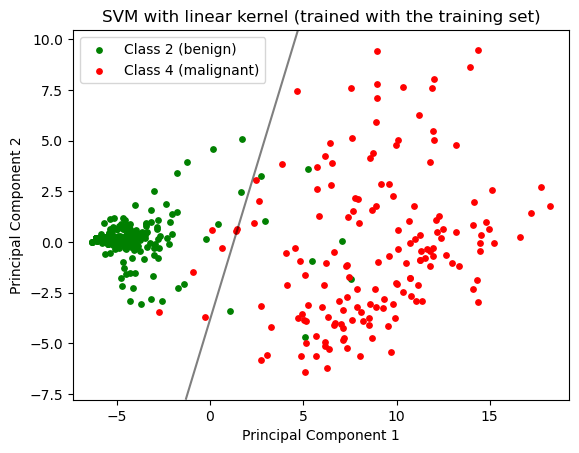

In [22]:
classes = [2,4]
colors = ['g','r']

for kind, color in zip(classes, colors):
    indices = y_train == kind
    plt.scatter(pca_coordinates_train[indices,0],
                pca_coordinates_train[indices,1],
                c=color,
                s=15)

xmin = min(df_principal_train_with_class['PC1'].min() , min(pca_coordinates_test[:,0]))
xmax = max(df_principal_train_with_class['PC1'].max() , max(pca_coordinates_test[:,0]))
ymin = min(df_principal_train_with_class['PC2'].min() , min(pca_coordinates_test[:,1]))
ymax = max(df_principal_train_with_class['PC2'].max() , max(pca_coordinates_test[:,1]))

xx = np.linspace(xmin-1, xmax+1, 1000)
yy = np.linspace(ymin-1, ymax+1, 1000)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = linear_SVM_model.decision_function(xy).reshape(XX.shape)

ax = plt.gca()
ax.contour(XX, YY, Z, colors='k', levels=0, alpha=0.5)
ax.scatter(linear_SVM_model.support_vectors_[:,0],
           linear_SVM_model.support_vectors_[:,1],
           facecolors='none',
           edgecolors='none')
    
plt.title('SVM with linear kernel (trained with the training set)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(['Class 2 (benign)','Class 4 (malignant)'])

plt.show()

After having obtained the separating line with the training data, we now plot it along with the test data to see how well the separation generalizes to unseen data:

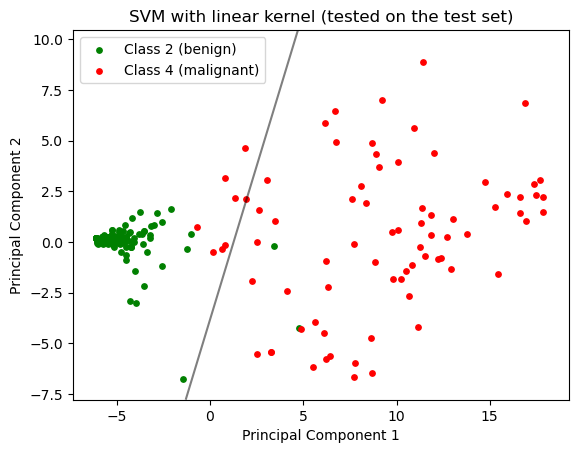

In [23]:
classes = [2,4]
colors = ['g','r']

for kind, color in zip(classes, colors):
    indices = y_test == kind
    plt.scatter(pca_coordinates_test[indices,0],
                pca_coordinates_test[indices,1],
                c=color,
                s=15)

xmin = min(df_principal_train_with_class['PC1'].min() , min(pca_coordinates_test[:,0]))
xmax = max(df_principal_train_with_class['PC1'].max() , max(pca_coordinates_test[:,0]))
ymin = min(df_principal_train_with_class['PC2'].min() , min(pca_coordinates_test[:,1]))
ymax = max(df_principal_train_with_class['PC2'].max() , max(pca_coordinates_test[:,1]))

xx = np.linspace(xmin-1, xmax+1, 1000)
yy = np.linspace(ymin-1, ymax+1, 1000)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = linear_SVM_model.decision_function(xy).reshape(XX.shape)

ax = plt.gca()
ax.contour(XX, YY, Z, colors='k', levels=0, alpha=0.5)
ax.scatter(linear_SVM_model.support_vectors_[:,0],
           linear_SVM_model.support_vectors_[:,1],
           facecolors='none',
           edgecolors='none')
    
plt.title('SVM with linear kernel (tested on the test set)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(['Class 2 (benign)','Class 4 (malignant)'])

plt.show()

In addition to the above graphical representation, we explicitly obtain the predictions on the test set:

In [24]:
predictions_linear_kernel = linear_SVM_model.predict(pca_coordinates_test)

We show the number of correct and incorrect predictions and the accuracy of the model (in percent to the nearest decimal place):

In [25]:
print('The SVM with linear kernel produces '
      +str(sum(predictions_linear_kernel==y_test))
      +' correct predictions and '
      +str(len(y_test)-sum(predictions_linear_kernel==y_test))
      +' incorrect predictions on the test set\n')

print('The accuracy is '+str(round(100*accuracy_score(y_test,predictions_linear_kernel),1))+'%')

The SVM with linear kernel produces 195 correct predictions and 10 incorrect predictions on the test set

The accuracy is 95.1%


The corresponding confusion matrix for this SVM with linear kernel after making predictions on the test set is:

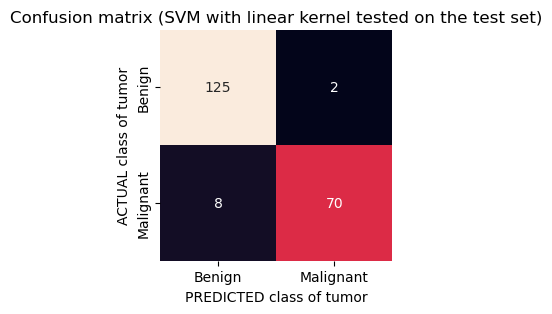

In [26]:
plt.figure(figsize=(3,3))

sns.heatmap(confusion_matrix(y_test,predictions_linear_kernel),
            annot=True,
            fmt='g',
            cbar=False,
            xticklabels=['Benign','Malignant'],
            yticklabels=['Benign','Malignant'])

plt.title('Confusion matrix (SVM with linear kernel tested on the test set)')
plt.xlabel('PREDICTED class of tumor')
plt.ylabel('ACTUAL class of tumor')

plt.show()

### Polynomial kernel

In this case, the mathematical formula for the kernel is a polynomial. To keep it simple, we will consider a polynomial of degree 3 and specify a non-zero independent term to adjust the position of the separating curve.

We fit the model using the training set:

In [27]:
poly_SVM_model = SVC(kernel='poly', degree=3, coef0=1)
poly_SVM_model.fit(pca_coordinates_train, y_train);

We plot the training data along with the separating curve to see how the decision boundary was obtained:

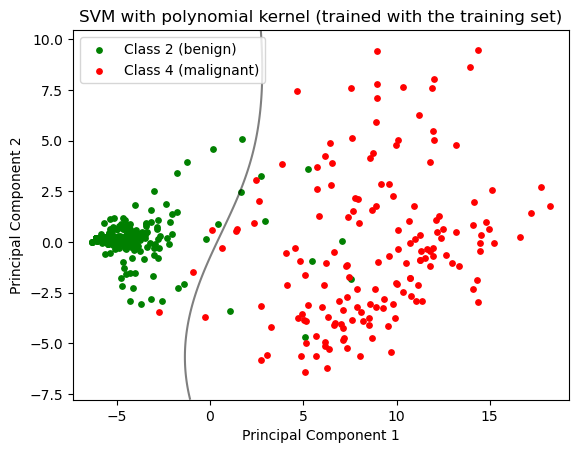

In [28]:
classes = [2,4]
colors = ['g','r']

for kind, color in zip(classes, colors):
    indices = y_train == kind
    plt.scatter(pca_coordinates_train[indices,0],
                pca_coordinates_train[indices,1],
                c=color,
                s=15)

xmin = min(df_principal_train_with_class['PC1'].min() , min(pca_coordinates_test[:,0]))
xmax = max(df_principal_train_with_class['PC1'].max() , max(pca_coordinates_test[:,0]))
ymin = min(df_principal_train_with_class['PC2'].min() , min(pca_coordinates_test[:,1]))
ymax = max(df_principal_train_with_class['PC2'].max() , max(pca_coordinates_test[:,1]))

xx = np.linspace(xmin-1, xmax+1, 1000)
yy = np.linspace(ymin-1, ymax+1, 1000)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = poly_SVM_model.decision_function(xy).reshape(XX.shape)

ax = plt.gca()
ax.contour(XX, YY, Z, colors='k', levels=0, alpha=0.5)
ax.scatter(poly_SVM_model.support_vectors_[:,0],
           poly_SVM_model.support_vectors_[:,1],
           facecolors='none',
           edgecolors='none')
    
plt.title('SVM with polynomial kernel (trained with the training set)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(['Class 2 (benign)','Class 4 (malignant)'])

plt.show()

After having obtained the separating curve with the training data, we now plot it along with the test data to see how well the separation generalizes to unseen data:

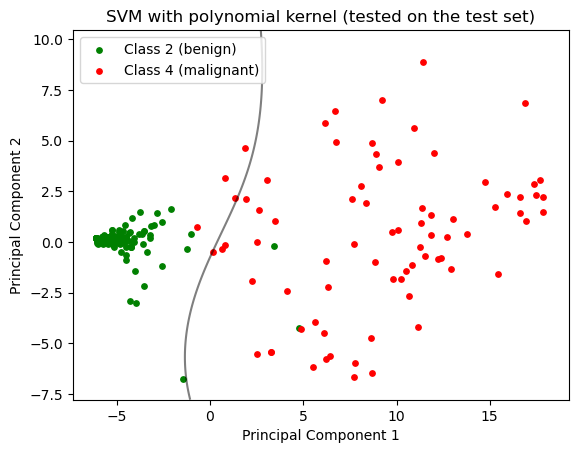

In [29]:
classes = [2,4]
colors = ['g','r']

for kind, color in zip(classes, colors):
    indices = y_test == kind
    plt.scatter(pca_coordinates_test[indices,0],
                pca_coordinates_test[indices,1],
                c=color,
                s=15)

xmin = min(df_principal_train_with_class['PC1'].min() , min(pca_coordinates_test[:,0]))
xmax = max(df_principal_train_with_class['PC1'].max() , max(pca_coordinates_test[:,0]))
ymin = min(df_principal_train_with_class['PC2'].min() , min(pca_coordinates_test[:,1]))
ymax = max(df_principal_train_with_class['PC2'].max() , max(pca_coordinates_test[:,1]))

xx = np.linspace(xmin-1, xmax+1, 1000)
yy = np.linspace(ymin-1, ymax+1, 1000)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = poly_SVM_model.decision_function(xy).reshape(XX.shape)

ax = plt.gca()
ax.contour(XX, YY, Z, colors='k', levels=0, alpha=0.5)
ax.scatter(poly_SVM_model.support_vectors_[:,0],
           poly_SVM_model.support_vectors_[:,1],
           facecolors='none',
           edgecolors='none')
    
plt.title('SVM with polynomial kernel (tested on the test set)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(['Class 2 (benign)','Class 4 (malignant)'])

plt.show()

In addition to the above graphical representation, we explicitly obtain the predictions on the test set:

In [30]:
predictions_poly_kernel = poly_SVM_model.predict(pca_coordinates_test)

We show the number of correct and incorrect predictions and the accuracy of the model (in percent to the nearest decimal place):

In [31]:
print('The SVM with polynomial kernel produces '
      +str(sum(predictions_poly_kernel==y_test))
      +' correct predictions and '
      +str(len(y_test)-sum(predictions_poly_kernel==y_test))
      +' incorrect predictions on the test set\n')

print('The accuracy is '+str(round(100*accuracy_score(y_test,predictions_poly_kernel),1))+'%')

The SVM with polynomial kernel produces 199 correct predictions and 6 incorrect predictions on the test set

The accuracy is 97.1%


The corresponding confusion matrix for this SVM with polynomial kernel after making predictions on the test set is:

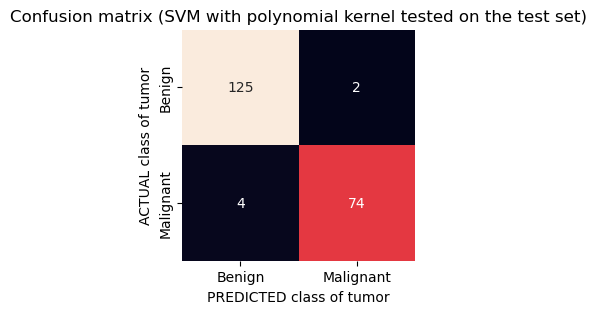

In [32]:
plt.figure(figsize=(3,3))

sns.heatmap(confusion_matrix(y_test,predictions_poly_kernel),
            annot=True,
            fmt='g',
            cbar=False,
            xticklabels=['Benign','Malignant'],
            yticklabels=['Benign','Malignant'])

plt.title('Confusion matrix (SVM with polynomial kernel tested on the test set)')
plt.xlabel('PREDICTED class of tumor')
plt.ylabel('ACTUAL class of tumor')

plt.show()

### Radial basis function kernel

Now, the kernel is a radial basis function, i.e., a function whose value depends only on the distance between the input and a fixed point.

We fit the model using the training set:

In [33]:
rbf_SVM_model = SVC(kernel='rbf')
rbf_SVM_model.fit(pca_coordinates_train, y_train);

We plot the training data along with the separating curve to see how the decision boundary was obtained:

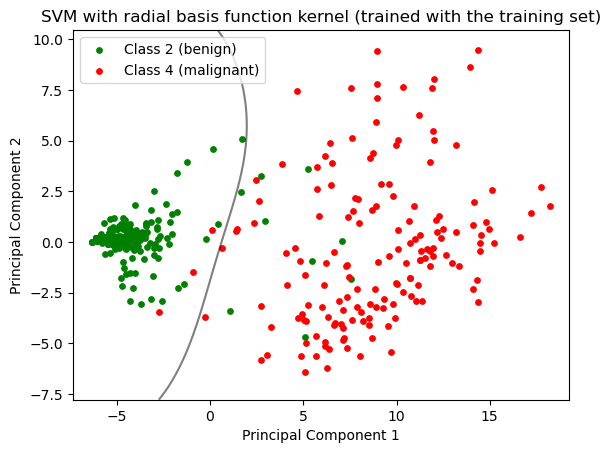

In [34]:
classes = [2,4]
colors = ['g','r']

for kind, color in zip(classes, colors):
    indices = y_train == kind
    plt.scatter(pca_coordinates_train[indices,0],
                pca_coordinates_train[indices,1],
                c=color,
                s=15)

xmin = min(df_principal_train_with_class['PC1'].min() , min(pca_coordinates_test[:,0]))
xmax = max(df_principal_train_with_class['PC1'].max() , max(pca_coordinates_test[:,0]))
ymin = min(df_principal_train_with_class['PC2'].min() , min(pca_coordinates_test[:,1]))
ymax = max(df_principal_train_with_class['PC2'].max() , max(pca_coordinates_test[:,1]))

xx = np.linspace(xmin-1, xmax+1, 1000)
yy = np.linspace(ymin-1, ymax+1, 1000)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = rbf_SVM_model.decision_function(xy).reshape(XX.shape)

ax = plt.gca()
ax.contour(XX, YY, Z, colors='k', levels=0, alpha=0.5)
ax.scatter(rbf_SVM_model.support_vectors_[:,0],
           rbf_SVM_model.support_vectors_[:,1],
           facecolors='none',
           edgecolors='none')
    
plt.title('SVM with radial basis function kernel (trained with the training set)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(['Class 2 (benign)','Class 4 (malignant)'])

plt.show()

After having obtained the separating curve with the training data, we now plot it along with the test data to see how well the separation generalizes to unseen data:

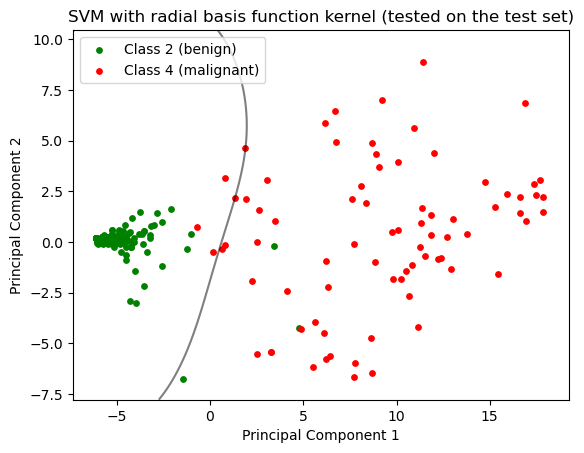

In [35]:
classes = [2,4]
colors = ['g','r']

for kind, color in zip(classes, colors):
    indices = y_test == kind
    plt.scatter(pca_coordinates_test[indices,0],
                pca_coordinates_test[indices,1],
                c=color,
                s=15)

xmin = min(df_principal_train_with_class['PC1'].min() , min(pca_coordinates_test[:,0]))
xmax = max(df_principal_train_with_class['PC1'].max() , max(pca_coordinates_test[:,0]))
ymin = min(df_principal_train_with_class['PC2'].min() , min(pca_coordinates_test[:,1]))
ymax = max(df_principal_train_with_class['PC2'].max() , max(pca_coordinates_test[:,1]))

xx = np.linspace(xmin-1, xmax+1, 1000)
yy = np.linspace(ymin-1, ymax+1, 1000)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = rbf_SVM_model.decision_function(xy).reshape(XX.shape)

ax = plt.gca()
ax.contour(XX, YY, Z, colors='k', levels=0, alpha=0.5)
ax.scatter(rbf_SVM_model.support_vectors_[:,0],
           rbf_SVM_model.support_vectors_[:,1],
           facecolors='none',
           edgecolors='none')
    
plt.title('SVM with radial basis function kernel (tested on the test set)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(['Class 2 (benign)','Class 4 (malignant)'])

plt.show()

In addition to the above graphical representation, we explicitly obtain the predictions on the test set:

In [36]:
predictions_rbf_kernel = rbf_SVM_model.predict(pca_coordinates_test)

We show the number of correct and incorrect predictions and the accuracy of the model (in percent to the nearest decimal place):

In [37]:
print('The SVM with radial basis function kernel produces '
      +str(sum(predictions_rbf_kernel==y_test))
      +' correct predictions and '
      +str(len(y_test)-sum(predictions_rbf_kernel==y_test))
      +' incorrect predictions on the test set\n')

print('The accuracy is '+str(round(100*accuracy_score(y_test,predictions_rbf_kernel),1))+'%')

The SVM with radial basis function kernel produces 197 correct predictions and 8 incorrect predictions on the test set

The accuracy is 96.1%


The corresponding confusion matrix for this SVM with radial basis function kernel after making predictions on the test set is:

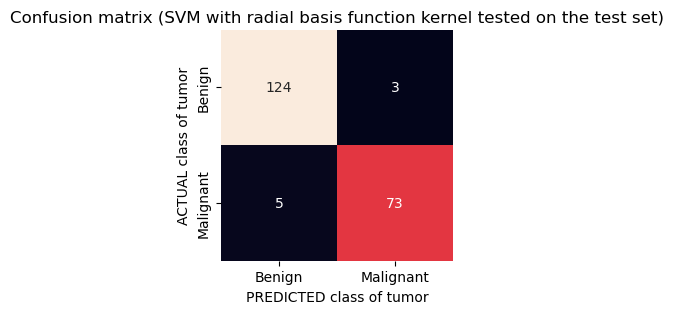

In [38]:
plt.figure(figsize=(3,3))

sns.heatmap(confusion_matrix(y_test,predictions_rbf_kernel),
            annot=True,
            fmt='g',
            cbar=False,
            xticklabels=['Benign','Malignant'],
            yticklabels=['Benign','Malignant'])

plt.title('Confusion matrix (SVM with radial basis function kernel tested on the test set)')
plt.xlabel('PREDICTED class of tumor')
plt.ylabel('ACTUAL class of tumor')

plt.show()

----------------------------------------

# Applying the models to new patients

If you want to use the model to predict the type of tumor of one or more new patients, enter the biological features in the next cell to generate new instances (separated by commas within each square bracket in the case of more than one patient). An example is provided.

In [39]:
new_data = pd.DataFrame(data={'Clump Thickness': [ 1 , 4 , 2 , 6 , 5 , 9 ] ,
                              'Uniformity of Cell Size': [ 3 , 7 , 1 , 3 , 2 , 5 ] ,
                              'Uniformity of Cell Shape': [ 5 , 4 , 7 , 2 , 1 , 6 ] ,
                              'Marginal Adhesion': [ 2 , 1 , 2 , 7 , 1 , 2 ] ,
                              'Single Epithelial Cell Size': [ 4 , 2 , 1 , 5 , 6 , 1 ] ,
                              'Bare Nuclei': [ 2 , 10 , 3 , 6 , 2 , 7 ] ,
                              'Bland Chromatin': [ 1 , 2 , 2 , 8 , 4 , 6 ] ,
                              'Normal Nucleoli': [ 1 , 5 , 2 , 3 , 1 , 4 ] ,
                              'Mitoses': [ 2 , 6 , 3 , 4 , 1 , 7 ]})

new_data.index = np.arange(1, len(new_data)+1)
new_data.index.name = 'Patient Number'

The following patients (rows) have been entered:

In [40]:
new_data

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
Patient Number,,,,,,,,,
1,1,3,5,2,4,2,1,1,2
2,4,7,4,1,2,10,2,5,6
3,2,1,7,2,1,3,2,2,3
4,6,3,2,7,5,6,8,3,4
5,5,2,1,1,6,2,4,1,1
6,9,5,6,2,1,7,6,4,7


Then, we transform the data into the new coordinate system that the PCA produced.

In [41]:
new_data_pca_transformed = pca_train.transform(new_data)

Their coordinates in the two-dimensional space of principal components are:

In [42]:
new_data_pca_transformed

array([[-2.23683871,  1.06090178],
       [ 4.65561459, -2.51123239],
       [-1.55276558,  0.19703499],
       [ 4.56910165, -1.75838789],
       [-2.17157334,  0.30793937],
       [ 5.73857057, -1.02954907]])

Finally we make the predictions using the SVM models. Three models were trained with different kernel functions: `linear_SVM_model`, `poly_SVM_model` and `rbf_SVM_model`.

In [43]:
new_prediction_linear = linear_SVM_model.predict(new_data_pca_transformed)
new_prediction_poly = poly_SVM_model.predict(new_data_pca_transformed)
new_prediction_rbf = rbf_SVM_model.predict(new_data_pca_transformed)

diagnoses_linear = []
diagnoses_poly = []
diagnoses_rbf = []

for i in range(len(new_data)):
    
    if new_prediction_linear[i] == 2:
        diagnoses_linear.append('Benign')
    if new_prediction_linear[i] == 4:
        diagnoses_linear.append('Malignant')
        
    if new_prediction_poly[i] == 2:
        diagnoses_poly.append('Benign')
    if new_prediction_poly[i] == 4:
        diagnoses_poly.append('Malignant')
        
    if new_prediction_rbf[i] == 2:
        diagnoses_rbf.append('Benign')
    if new_prediction_rbf[i] == 4:
        diagnoses_rbf.append('Malignant')

For the new patients who have been introduced above, these are the predictions:

In [44]:
print('Prediction(s) using the SVM with linear kernel function:\n')

for i in range(len(new_data)):
    print('Diagnosis of patient '+str(i+1)+': '+diagnoses_linear[i]+' tumor')

Prediction(s) using the SVM with linear kernel function:

Diagnosis of patient 1: Benign tumor
Diagnosis of patient 2: Malignant tumor
Diagnosis of patient 3: Benign tumor
Diagnosis of patient 4: Malignant tumor
Diagnosis of patient 5: Benign tumor
Diagnosis of patient 6: Malignant tumor


In [45]:
print('Prediction(s) using the SVM with polynomial kernel function:\n')

for i in range(len(new_data)):
    print('Diagnosis of patient '+str(i+1)+': '+diagnoses_poly[i]+' tumor')

Prediction(s) using the SVM with polynomial kernel function:

Diagnosis of patient 1: Benign tumor
Diagnosis of patient 2: Malignant tumor
Diagnosis of patient 3: Benign tumor
Diagnosis of patient 4: Malignant tumor
Diagnosis of patient 5: Benign tumor
Diagnosis of patient 6: Malignant tumor


In [46]:
print('Prediction(s) using the SVM with radial basis kernel function:\n')

for i in range(len(new_data)):
    print('Diagnosis of patient '+str(i+1)+': '+diagnoses_rbf[i]+' tumor')

Prediction(s) using the SVM with radial basis kernel function:

Diagnosis of patient 1: Benign tumor
Diagnosis of patient 2: Malignant tumor
Diagnosis of patient 3: Benign tumor
Diagnosis of patient 4: Malignant tumor
Diagnosis of patient 5: Benign tumor
Diagnosis of patient 6: Malignant tumor


In general, we should expect accurate and similar predictions for the three models in most cases. However, the separation mechanism is different in each model. There could be disagreement in a borderline case of a not clearly classifiable patient whose position in the two-dimensional space of principal components is very close to the area where the models draw their decision boundaries.

-------------------------------------

# Conclusion

PCA has simplified the dataset and clarified the structure of the data. The new coordinates of the data reveal that, in general, there are significant differences between the biological variables of patients with a benign tumor and patients with a malignant tumor. This allows us to distinguish very precisely between the two types of patients. Inevitably, there are some outliers that prevent us from obtaining an absolutely perfect classification if we do not want to overfit. However, the high accuracy of these models illustrates how machine learning techniques can be a very useful tool in the medical field to help make diagnoses. Of course, the final diagnosis should always be made by a qualified physician who evaluates each clinical case individually, but these models can be an additional tool for decision making. As for further work, it would be recommended to apply a cross-validation technique for a more general evaluation of the performance of the models. Also, within this framework, it could be useful to perform a more thorough tuning of hyperparameters such as the regularization parameter `C` or the kernel coefficient `gamma`, which may slightly improve the performance of the models.